In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors

import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# zones = pd.read_csv(r"G:\Mon Drive\Fichiers\2.Scolarité\1. Jedha_Data_Science\CERTIF_PROJECTS\Src_uber-non git\taxi-zone-lookup.csv")
# dataset_04 = pd.read_csv(r"G:\Mon Drive\Fichiers\2.Scolarité\1. Jedha_Data_Science\CERTIF_PROJECTS\Src_uber-non git\uber-raw-data-apr14.csv")

zones = pd.read_csv("/content/drive/MyDrive/Fichiers/2.Scolarité/1. Jedha_Data_Science/CERTIF_PROJECTS/Src_uber-non git/taxi-zone-lookup.csv")
dataset_04 = pd.read_csv("/content/drive/MyDrive/Fichiers/2.Scolarité/1. Jedha_Data_Science/CERTIF_PROJECTS/Src_uber-non git/uber-raw-data-apr14.csv")

In [5]:
zones.head()

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


In [6]:
print("general info : ")
display(zones.info())
print()

print("Basics statistics: ")
data_zones_desc = zones.describe(include='all')
display(data_zones_desc)
print()

general info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   LocationID  265 non-null    int64 
 1   Borough     265 non-null    object
 2   Zone        265 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.3+ KB


None


Basics statistics: 


,LocationID,Borough,Zone
count,265.000000,265,265
unique,NaN,7,261
top,NaN,Queens,Governor's Island/Ellis Island/Liberty Island
freq,NaN,69,3
mean,133.000000,NaN,NaN
std,76.643112,NaN,NaN
min,1.000000,NaN,NaN
25%,67.000000,NaN,NaN
50%,133.000000,NaN,NaN
75%,199.000000,NaN,NaN


In [7]:
print("general info : ")
display(dataset_04.info())
print()

print("Basics statistics: ")
data_uber_desc = dataset_04.describe(include='all')
display(data_uber_desc)
print()

general info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  564516 non-null  object 
 1   Lat        564516 non-null  float64
 2   Lon        564516 non-null  float64
 3   Base       564516 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.2+ MB


None


Basics statistics: 


,Date/Time,Lat,Lon,Base
count,564516,564516.000000,564516.000000,564516
unique,41999,NaN,NaN,5
top,4/7/2014 20:21:00,NaN,NaN,B02682
freq,97,NaN,NaN,227808
mean,NaN,40.740005,-73.976817,NaN
std,NaN,0.036083,0.050426,NaN
min,NaN,40.072900,-74.773300,NaN
25%,NaN,40.722500,-73.997700,NaN
50%,NaN,40.742500,-73.984800,NaN
75%,NaN,40.760700,-73.970000,NaN


#### Process datetime and pick one hour sample

In [8]:
dataset_04["Date/Time"] = pd.to_datetime(dataset_04["Date/Time"])

# dataset_04['Year'] = pd.to_datetime(dataset_04['Date']).dt.year
# dataset_04['Month'] = pd.to_datetime(dataset_04['Date']).dt.month
# dataset_04['Day'] = pd.to_datetime(dataset_04['Date']).dt.day
# dataset_04['Week_day'] = pd.to_datetime(dataset_04['Date']).dt.dayofweek

In [9]:
dataset_04["Date/Time"].value_counts(ascending=False)

Date/Time
2014-04-07 20:21:00    97
2014-04-07 20:22:00    87
2014-04-30 17:45:00    78
2014-04-30 18:43:00    70
2014-04-30 19:00:00    70
                       ..
2014-04-29 04:08:00     1
2014-04-27 09:26:00     1
2014-04-29 03:27:00     1
2014-04-29 03:16:00     1
2014-04-30 02:55:00     1
Name: count, Length: 41999, dtype: int64

In [10]:
mask_1 = dataset_04["Date/Time"] == "2014-04-07 20:21:00"
dataset_sample = dataset_04.loc[mask_1, :]
print(dataset_sample.shape[0])
display(dataset_sample.head())

97


,Date/Time,Lat,Lon,Base
8945,2014-04-07 20:21:00,40.7431,-74.0083,B02512
8946,2014-04-07 20:21:00,40.7066,-74.0084,B02512
8947,2014-04-07 20:21:00,40.7514,-73.9709,B02512
8948,2014-04-07 20:21:00,40.7178,-73.9941,B02512
8949,2014-04-07 20:21:00,40.7449,-74.0061,B02512


Visualising data on a map

In [11]:
fig = px.scatter_mapbox(dataset_sample, lat="Lat", lon="Lon", color="Base", mapbox_style="carto-positron")
fig.show()

### K-Means test

In [12]:
# Preprocessing. We will keep only standard scaled values of lat & lon since we are working on a sample of time.
# We assume that "Base" does not provide meaningful information for the moment.

In [13]:
dataset_sample_kmeans = dataset_sample[["Lat","Lon"]]
scaler = StandardScaler()
sc_dataset_sample_kmeans = scaler.fit_transform(dataset_sample_kmeans)

In [14]:
wcss =  []
k = []

for i in range (2,12):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 100)
    kmeans.fit(sc_dataset_sample_kmeans)
    wcss.append(kmeans.inertia_)
    k.append(i)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))

WCSS for K=2 --> 129.8004574613853
WCSS for K=3 --> 79.31242966164776
WCSS for K=4 --> 43.160219601519245
WCSS for K=5 --> 29.750392738575666
WCSS for K=6 --> 21.05532969461724
WCSS for K=7 --> 16.09537301579591
WCSS for K=8 --> 13.081374241744419
WCSS for K=9 --> 10.710730145941206
WCSS for K=10 --> 8.417350686612806
WCSS for K=11 --> 6.6757089007571295


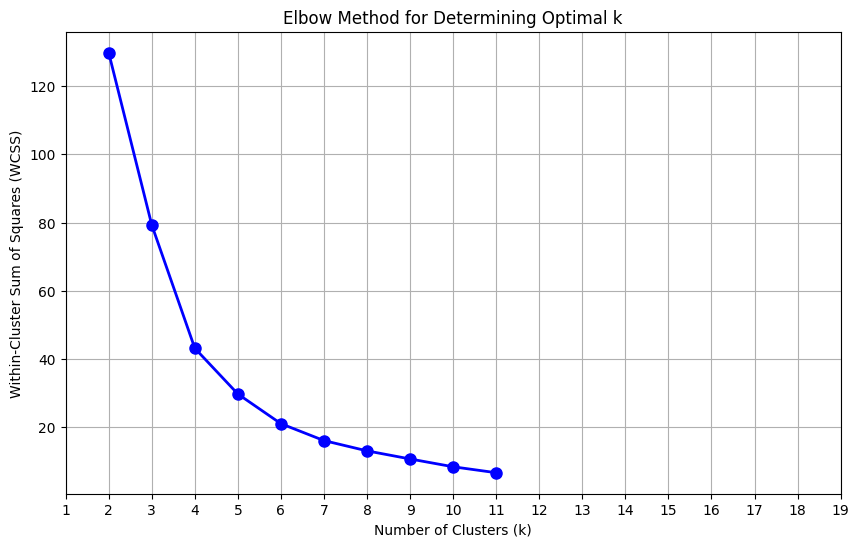

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(k, wcss, 'bo-', markersize=8, linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal k')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

In [16]:
kmeans_test_1 = KMeans(n_clusters=6, random_state=0)
kmeans_test_1.fit(sc_dataset_sample_kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=6, random_state=0)

In [17]:
dataset_sample_kmeans["cluster_kmeans"] = kmeans_test_1.labels_

<ipython-input-17-d28f6dbacd08>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
fig = px.scatter_mapbox(dataset_sample_kmeans,
                        lat='Lat',
                        lon='Lon',
                        color='cluster_kmeans',
                        mapbox_style="carto-positron",
                        title='K-Means Clustering of Rides',
                        height=800)

fig.update_layout(
    mapbox=dict(
        center=dict(lat=dataset_sample_kmeans['Lat'].mean(), lon=dataset_sample_kmeans['Lon'].mean())
    ),
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig.show()

### DBScan test

In [19]:
# We will take the standard scaled dataset sample used for KMeans test.

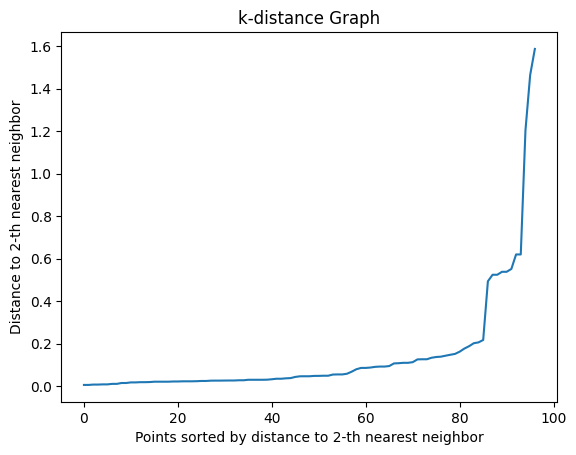

In [20]:
# Determining optimal EPS

# Convert latitude and longitude to radians for haversine distance
# data_radians = np.radians(sc_dataset_sample_kmeans)

k = 2  # Set k to test value of min_samples
nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(sc_dataset_sample_kmeans)
distances, indices = nbrs.kneighbors(sc_dataset_sample_kmeans)

# Sort the distances to the k-th nearest neighbor
k_distances = distances[:, k-1]
k_distances.sort()

# Plotting
plt.plot(k_distances)
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
plt.ylabel('Distance to {}-th nearest neighbor'.format(k))
plt.title('k-distance Graph')
plt.show()

In [21]:
# Determining optimal min_samples

eps = 0.2  # Set eps to test value of Epsilon
min_samples_range = range(2, 20)  # Example range for min_samples
best_score = -1
best_min_samples = 0

for min_samples in min_samples_range:
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(sc_dataset_sample_kmeans)
    labels = db.labels_
    # Only calculate silhouette score if there are more than 1 cluster
    if len(set(labels)) > 1:
        score = silhouette_score(sc_dataset_sample_kmeans, labels, metric='euclidean')
        if score > best_score:
            best_score = score
            best_min_samples = min_samples

print('Best silhouette score:', best_score)
print('Optimal min_samples:', best_min_samples)

Best silhouette score: 0.447451833890122
Optimal min_samples: 2


In [22]:
db_test_1 = DBSCAN(eps=0.2, min_samples=2, metric="euclidean", algorithm="brute")
db_test_1.fit(sc_dataset_sample_kmeans)

DBSCAN(algorithm='brute', eps=0.2, min_samples=2)

In [23]:
dataset_sample_kmeans["cluster_dbscan"] = db_test_1.labels_

In [24]:
fig = px.scatter_mapbox(dataset_sample_kmeans,
                        lat='Lat',
                        lon='Lon',
                        color='cluster_dbscan',
                        mapbox_style="carto-positron",
                        title='DBScan Clustering of Rides',
                        height=800)

fig.update_layout(
    mapbox=dict(
        center=dict(lat=dataset_sample_kmeans['Lat'].mean(), lon=dataset_sample_kmeans['Lon'].mean())
    ),
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig.show()

### Full dataset clustering models

In [25]:
#Pre-processing full dataset

dataset_04['Week_day'] = pd.to_datetime(dataset_04['Date/Time']).dt.dayofweek

dataset_04_weekday = dataset_04.drop(columns = ["Base","Date/Time","Hour"])

In [26]:
#check
print(dataset_04_weekday['Week_day'].value_counts())
print(dataset_04_hour['Hour'].value_counts())

Week_day
2    108631
1     91185
4     90303
3     85067
5     77218
0     60861
6     51251
Name: count, dtype: int64
Hour
17    45475
18    43003
16    42003
19    38923
21    36964
20    36244
15    35324
22    30645
14    27190
7     24924
8     22843
13    22603
23    20649
12    19425
11    18774
6     18498
9     17939
10    17865
0     11910
5      9476
1      7769
4      6095
3      5040
2      4935
Name: count, dtype: int64


### Research of optimal parameters for KMeans

In [27]:
# Determining optimal EPS (sample 50_000 rows)
dataset_04_optimal_research = dataset_04[["Lat", "Lon"]].sample(n=50000)

In [31]:
wcss =  []
k = []

for i in range (2,12):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 20)
    kmeans.fit(dataset_04_optimal_research)
    wcss.append(kmeans.inertia_)
    k.append(i)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))

WCSS for K=2 --> 127.28173298186945
WCSS for K=3 --> 97.17724677410658
WCSS for K=4 --> 77.7668029543348
WCSS for K=5 --> 61.55521570492078
WCSS for K=6 --> 49.67060598118864
WCSS for K=7 --> 40.82997523201526
WCSS for K=8 --> 36.556044563487966
WCSS for K=9 --> 32.91230036174325
WCSS for K=10 --> 29.603571538072444
WCSS for K=11 --> 26.709646718849747


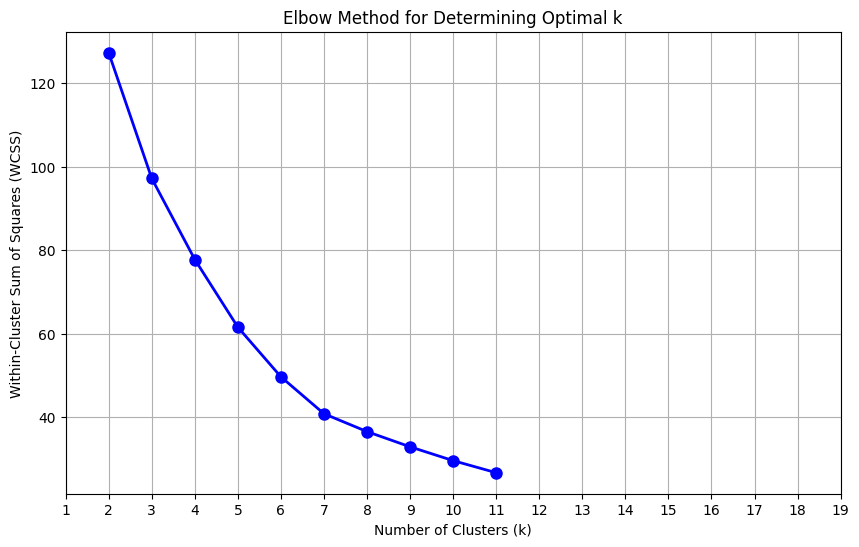

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(k, wcss, 'bo-', markersize=8, linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal k')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

In [30]:
# Computer mean silhouette score
sil = []
k = []

for i in range (2,11):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 100)
    kmeans.fit(data_radians)
    sil.append(silhouette_score(data_radians, kmeans.predict(data_radians)))
    k.append(i)
    print("Silhouette score for K={} is {}".format(i, sil[-1]))

Silhouette score for K=2 is 0.7313891588148063
Silhouette score for K=3 is 0.3979614691115272
Silhouette score for K=4 is 0.42016430447610864
Silhouette score for K=5 is 0.43119477330410494
Silhouette score for K=6 is 0.46946173416764747
Silhouette score for K=7 is 0.4728281749274712
Silhouette score for K=8 is 0.4260252074942943
Silhouette score for K=9 is 0.4268060384705023
Silhouette score for K=10 is 0.4254952572184208


### Research of optimal parameters for DBScan

In [ ]:
# Convert latitude and longitude to radians for haversine distance
data_radians = np.radians(dataset_04_optimal_research)

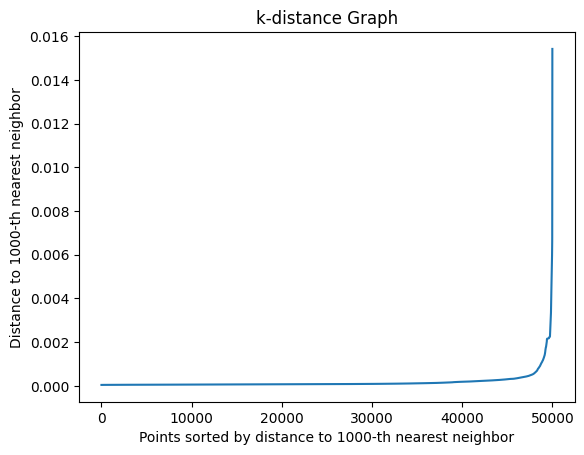

In [ ]:
# Determining optimal EPS

k = 1000  # Set k to test value of min_samples
nbrs = NearestNeighbors(n_neighbors=k, metric='haversine').fit(data_radians)
distances, indices = nbrs.kneighbors(data_radians)

# Sort the distances to the k-th nearest neighbor
k_distances = distances[:, k-1]
k_distances.sort()

# Plotting
plt.plot(k_distances)
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
plt.ylabel('Distance to {}-th nearest neighbor'.format(k))
plt.title('k-distance Graph')
plt.show()

In [ ]:
# Determining optimal min_samples

eps = 0.001  # Set eps to test value of Epsilon
min_samples_range = range(500, 5500, 500)  # Example range for min_samples
best_score = -1
best_min_samples = 0

for min_samples in min_samples_range:
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit(data_radians)
    labels = db.labels_
    # Only calculate silhouette score if there are more than 1 cluster
    if len(set(labels)) > 1:
        score = silhouette_score(data_radians, labels, metric='haversine')
        if score > best_score:
            best_score = score
            best_min_samples = min_samples

print('Best silhouette score:', best_score)
print('Optimal min_samples:', best_min_samples)

In [ ]:
#DBScan : Test without preprocessing the data of Lon/Len and using Haversine distance.

#Training models and Visualizing

##KMeans

In [40]:
clustered_data = []
n_clusters = 7

# Iterate through each day of the week
for day in range(7):
    filtered_data = dataset_04_weekday[dataset_04_weekday['Week_day'] == day]

    # Check if filtered_data is not empty to avoid errors
    if not filtered_data.empty:
        pickup_locations = filtered_data[['Lat', 'Lon']]

        # KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(pickup_locations)

        # Add cluster labels and centers to the dataframe
        filtered_data['Cluster'] = kmeans.labels_ + (day * n_clusters)

        clustered_data.append(filtered_data)

clustered_data_kmeans = pd.concat(clustered_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-40-f5b49d87d728>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-40-f5b49d87d728>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [47]:
#Check
display(clustered_data_kmeans.head())
print(clustered_data_kmeans["Cluster"].nunique())

,Lat,Lon,Week_day,Cluster
7785,40.7205,-73.9939,0,5
7786,40.7407,-74.0077,0,5
7787,40.7591,-73.9892,0,0
7788,40.7419,-74.0034,0,5
7789,40.7419,-74.0034,0,5


49


In [65]:
def create_scattermapbox(day_data, day):
    return go.Scattermapbox(
        lat=day_data['Lat'],
        lon=day_data['Lon'],
        mode='markers',
        marker=dict(
            size=9,
            color=day_data['Cluster'],
            colorscale='Viridis',
            showscale=False
        ),
        text=day_data['Cluster'],
        hoverinfo='text',
        name=f'Day {day}'
    )

# Create the figure
fig = go.Figure()

# Add scattermapbox traces for each day of the week
for day in range(7):
  day_data = clustered_data_kmeans[clustered_data_kmeans['Week_day'] == day]
  trace = create_scattermapbox(day_data, day)
  trace['visible'] = day == 0
  fig.add_trace(trace)

# Update layout for the map
fig.update_layout(
    updatemenus=[
        {
            'buttons': [
                {
                    'label': 'Monday',
                    'method': 'update',
                    'args': [{'visible': [day == 0 for day in range(7)]}]
                },
                {
                    'label': 'Tuesday',
                    'method': 'update',
                    'args': [{'visible': [day == 1 for day in range(7)]}]
                },
                {
                    'label': 'Wednesday',
                    'method': 'update',
                    'args': [{'visible': [day == 2 for day in range(7)]}]
                },
                {
                    'label': 'Thursday',
                    'method': 'update',
                    'args': [{'visible': [day == 3 for day in range(7)]}]
                },
                {
                    'label': 'Friday',
                    'method': 'update',
                    'args': [{'visible': [day == 4 for day in range(7)]}]
                },
                {
                    'label': 'Saturday',
                    'method': 'update',
                    'args': [{'visible': [day == 5 for day in range(7)]}]
                },
                {
                    'label': 'Sunday',
                    'method': 'update',
                    'args': [{'visible': [day == 6 for day in range(7)]}]
                }
            ],
            'direction': 'down',
            'showactive': True,
        }
    ],
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=clustered_data_kmeans['Lat'].mean(), lon=clustered_data_kmeans['Lon'].mean()),
        zoom=10
    ),
    margin={"r":0,"t":0,"l":0,"b":0}
)

# Show the map
fig.show()

Output hidden; open in https://colab.research.google.com to view.

##DBScan